<a href="https://colab.research.google.com/github/abhiWriteCode/Pong/blob/master/Pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Install dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay matplotlib scikit-video > /dev/null 2>&1
!pip install --upgrade tensorflow > /dev/null 2>&1
!pip install gym[atari] 2>&1

In [0]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time
import utils

tf.__version__

'2.0.0'

In [0]:
env = gym.make("Pong-v0")
env.seed(1) # reproducible, since RL has high variance

[1, 289714752]

In [0]:
print ("Enviornment has observation space = {}".format(env.observation_space))

Enviornment has observation space = Box(210, 160, 3)


In [0]:
n_actions = env.action_space.n
print ("Number of possible actions that the agent can choose from = {}".format(n_actions))

Number of possible actions that the agent can choose from = 6


In [0]:
def create_pong_model():
    model = tf.keras.models.Sequential([
        # Define and reshape inputs
        tf.keras.layers.InputLayer(input_shape=(6400,), dtype=tf.float32),
        tf.keras.layers.Reshape((80, 80, 1)),

        # Convolutional layers
        tf.keras.layers.Conv2D(filters=16, kernel_size=(8,8), strides=(4,4), activation='relu', padding='same'),
        # Convolutional layer with 32 4x4 filters and 2x2 stride, ReLu activation
        tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),
        tf.keras.layers.Flatten(),

        # Fully connected layer and output
        tf.keras.layers.Dense(units=256, activation='relu'),
        # the output dimension of the last Dense layer
        # Hint: think about that the space the agent needs to act in
        tf.keras.layers.Dense(units=n_actions, activation=None)
    ])
    return model

pong_model = create_pong_model()

In [0]:
pong_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 80, 80, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 16)        1040      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        8224      
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               819456    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 830,262
Trainable params: 830,262
Non-trainable params: 0
__________________________________________________

In [0]:
def choose_action(model, observation):
    
    observation = observation.reshape([1, -1])
    
    '''feed the observations through the model to predict the log probabilities of each possible action.'''
    logits = model.predict(observation)

    # pass the log probabilities through a softmax to compute true probabilities
    prob_weights = tf.nn.softmax(logits).numpy()

    '''randomly sample from the prob_weights to pick an action.
    Hint: carefully consider the dimensionality of the input probabilities (vector) and the output action (scalar)'''
    action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]

    return action

In [0]:
from collections import deque

class Memory:
    def __init__(self, buffer_size=-1): 
        self.size = buffer_size
        self.clear()

    def clear(self):
        self.observations = deque() if self.size == -1 else deque(maxlen = self.size)
        self.actions = deque() if self.size == -1 else deque(maxlen = self.size)
        self.rewards = deque() if self.size == -1 else deque(maxlen = self.size)

    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        '''update the list of actions with new action'''
        self.actions.append(new_action)
        '''update the list of rewards with new reward'''
        self.rewards.append(new_reward)

In [0]:
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x

def discount_rewards(rewards, gamma=0.99): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # NEW: Reset sum
        if rewards[t] != 0:
            R = 0
        # update the total discounted reward as before
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)

In [0]:
def compute_loss(logits, actions, rewards): 
    '''complete the call to compute the loss'''
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions) 
    
    '''scale the negative log probability by the rewards'''
    loss = tf.reduce_mean( neg_logprob * rewards ) 
    
    return loss

In [0]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
    with tf.GradientTape() as tape:
        # Forward propogate through the agent
        observations = tf.convert_to_tensor(observations, dtype=tf.float32)
        logits = model(observations)

        '''call the compute_loss function to compute the loss'''
        loss = compute_loss(logits, actions, discounted_rewards) 

    '''run backpropagation using the tape.gradient method'''
    grads = tape.gradient(loss, model.variables) 
    optimizer.apply_gradients(zip(grads, model.variables))

In [0]:
def pre_process(image):
    I = image[35:195] # Crop
    I = I[::2, ::2, 0] # Downsample width and height by a factor of 2
    I[I == 144] = 0 # Remove background type 1
    I[I == 109] = 0 # Remove background type 2
    I[I != 0] = 1 # Set remaining elements (paddles, ball, etc.) to 1
    return I.astype(np.float).ravel()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


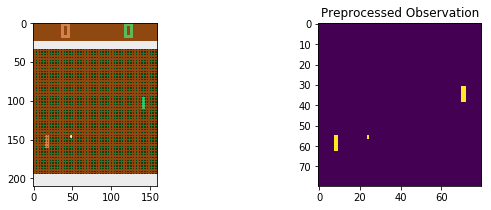

In [0]:
observation = env.reset()
for i in range(30):
    observation, _,_,_ = env.step(0)
observation_pp = pre_process(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid('off');
ax2.imshow(observation_pp.reshape((80,80))); ax2.grid('off'); plt.title('Preprocessed Observation')
plt.show()

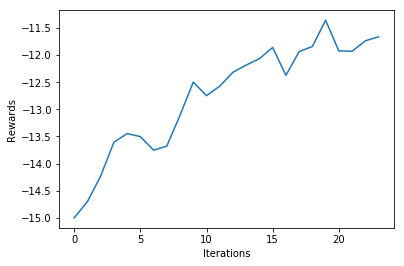

KeyboardInterrupt: ignored

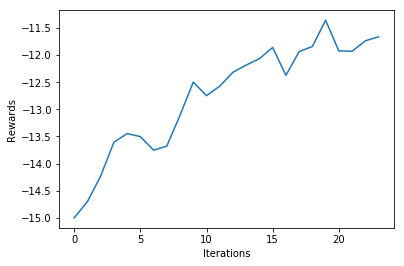

In [0]:
MAX_ITERS = 10000

smoothed_reward = utils.LossHistory(smoothing_factor=0.9)
plotter = utils.PeriodicPlotter(sec=10, xlabel='Iterations', ylabel='Rewards')

memory = Memory()
learning_rate=1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

for i_episode in range(MAX_ITERS):

    plotter.plot(smoothed_reward.get())

    # Restart the environment
    observation = env.reset()
    previous_frame = pre_process(observation)


    while True:
        # Pre-process image 
        current_frame = pre_process(observation)

        '''determine the observation change
        this is the difference between the past two frames'''
        obs_change = current_frame - previous_frame 

        '''choose an action for the pong model, using the frame difference, and evaluate'''
        action = choose_action(pong_model, obs_change) 
        
        # Take the chosen action
        next_observation, reward, done, info = env.step(action)
        
        '''save the observed frame difference, the action that was taken, and the resulting reward!'''
        memory.add_to_memory(obs_change, action, reward) 

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append( total_reward )

            # begin training
            train_step(pong_model, optimizer, 
                     observations = np.vstack(memory.observations), 
                     actions = np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
            
            memory.clear()
            break

        observation = next_observation
        previous_frame = current_frame

In [0]:
checkpoint = '3600.h5'
# pong_model.save(checkpoint)

In [0]:
# Evaluation Model

model_eval = create_pong_model()
model_eval.load_weights(checkpoint)

In [0]:
def save_video_of_model(model, env_name, filename='agent.mp4'):  
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(40, 30))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    shape = env.render(mode='rgb_array').shape[0:2]

    out = skvideo.io.FFmpegWriter(filename)

    previous_frame = pre_process(obs)
    done = False
    
    while not done: 
        frame = env.render(mode='rgb_array')
        out.writeFrame(frame)

        current_frame = pre_process(obs)

        obs_change = current_frame - previous_frame 

        input = tf.convert_to_tensor(obs_change.reshape((1,-1)), tf.float32)
        action = model(input).numpy().argmax()
        
        obs, reward, done, info = env.step(action)
        previous_frame = current_frame
    out.close()
    print ("Successfully saved into {}!".format(filename))

save_video_of_model_(model_eval, "Pong-v0", filename='pong_agent.mp4')

In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./pong_agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))